**This notebook contains a custom callback you may wish to copy and use
It is a combination of the Keras callbacks Reduce Learning Rate on Plateau,
Early Stopping and Model Checkpoint but eliminates some of the limitations
of each. In addition it provides an easier to read summary of the model's
performance at the end of each epoch. It also provides a handy feature
that enables you to set the number of epochs to train for until a message
asks if you wish to halt training on the current epoch by entering H or
to enter an integer which will determine how many more epochs to run
before the message appears again. This is very useful if you are training
a model and decide the metrics are satisfactory and you want to end
the model training early. Note the callback always returns your model
with the weights set to those of the epoch which had the highest performance
on the metric being monitored (accuracy or validation accuracy)
The callback initially monitors training accuracy and will adjust the learning
rate based on that until the accuracy reaches a user specified threshold
level. Once that level of training accuracy is achieved the callback switches
to monitoring validation loss and adjusts the learning rate based on that.
The callback prints the training data in the form of a spreadsheet. By specifying
a csv_path you can produce a csv file of this data. This is useful when you are
doing hyper-parameter tuning so you can compare training data from previous runs to
the data of the current run. The csv file produced is time stamped. It if of the form filename-month=day-year-hour-minute-seconds. the callback is of the form:
callbacks=[LRA(model, base_model, patience, stop_patience, threshold,factor, dwell, batches, initial_epoch, epochs, ask_epoch )]

where:

model is your compiled model
base_model is the name of your base_model if you are doing transfer learning.
for example you might have in your model
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') base_model.trainabel=False During training you will be asked if you want to do fine tuning
If you enter F to the query, the base_model will be set to trainable by the callback If you are not doing transfer learning set base_model==None
patience is an integer that determines many consecutive epochs can occur before the learning rate will be adjusted (similar to patience parameter in Reduce Learning Rate on Plateau)

stop_patience is an integer that determines hom many consecutive epochs for which the learning rate was adjusted but no improvement in the monitored metric occurred before training is halted(similar to patience parameter in early stopping)

threshold is a float that determines the level that training accuracy must achieve before the callback switches over to monitoring validation loss. This is useful for cases where the validation loss in early epochs tends to vary widely and can cause unwanted behavior when using the conventional Keras callbacks

factor is a float that determines the new learning rate by the equation lr=lr*factor. (similar to the factor parameter in Reduce Learning Rate on Plateau)
dwell is a boolean. It is used in the callback as part of an experiment on training models. If on a given epoch the metric being monitored fails to improve it means your model has moved to a location on the surface of Nspace (where N is the number of trainable parameters) that is NOT as favorable (poorer metric performance) than the position in Nspace you were in for the previous epoch. If dwell is set to True the callback loads the model with the weights from the previous (better metric value) epoch. Why move to a worse place if the place you were in previously was better. Then the learning rate is reduced for the next epoch of training. If dwell is set to false this action does not take place.
batches is an integer. It should be set to a value of batches=int(number of traing samples/batch_size). During training the callback provides information during an epoch of the form 'processing batch of batches accuracy= accuracy loss= loss where batch is the current batch being processs, batches is as described above, accuracy is the current training accuracy and loss is the current loss. Typically the message would appear as processing batch 25 of 50 accuracy: 54% loss: .04567. As each batch is processed these values are changed.
initial_epoch is an integer. Typically set this to zero Itis used in the information printed out for each epoch. In the case where you train the model say with the basemodel weights frozen say you train for 10 epochs. Then you want to fine tune the model and train for more eppochs for the second training session you would reinstantiate the callback and set initial_epoch=10.
epochs an integer value for the number of epochs to train
ask_epoch is either set to an integer value or None. If set to an integer it denotes the epoch number at which user input is requested. If the user enter H training is halted. If the user inters an integer it represents how many more epochs to run before you are asked for the user input again. If the user enters F the base_model is made trainable If ask_epoch is set to None the user is NOT asked to provide any input. This feature is handy is when training your model and the metrics are either unsatisfactory and you want to stop training, or for the case where your metrics are satisfactory and there is no need to train any further. Note you model is always set to the weights for the epoch that had the beset metric performance. So if you halt the training you can still use the model for predictions.
csv_path is a string representing the path location where the spreedsheet training data
csv file will be stored.
** Example of Use:
callbacks=[LRA(model=my_model, base_model=base_model, patience=1,stop_patience=3,
threshold=.9, factor=.5, dwell=True,batches=85, initial_epoch=0 , epochs=20, ask_epoch=5, 'c:\mycsv_file')] this implies:

your model is my_model
base_model is the name of your base_model if you are doing transfer learning
after 1 epoch of no improvement the learning rate will be reduced
after 3 consecutive adjustment of the leaarning rate with no metric improve training terminates
once the training accuracy reaches 90% the callback adjust learning rate based on validation loss
when the learning rate is adjust the new learning rate is .5 X learning rate
if the current epoch's metric value did not improve, the weights for the prior epoch are loaded and the learning rate is reduced
85 batches of data are run to complete an epoch
the initial epoch is 0
train for 20 epochs
after the fifth epoch you will be asked if you want to halt training by entering H or enter an integer denoting how many more epochs to run before you will be prompted again or enter T to make the base_model=trainable




**Importing** **Libraries**


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
import datetime
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print ('modules loaded')

modules loaded


***Define a function to show example training images***

In [2]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i]/255    
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

***Define a function to print text in RGB foreground and background colors¶***

In [3]:
def show_images(tdir):
    classlist=os.listdir(tdir)
    length=len(classlist)
    columns=5
    rows=int(np.ceil(length/columns))    
    plt.figure(figsize=(20, rows * 4))
    for i, klass in enumerate(classlist):    
        classpath=os.path.join(tdir, klass)
        imgpath=os.path.join(classpath, '1.jpg')
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(klass, color='blue', fontsize=12)
        plt.imshow(img)

In [4]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

***Define code for custom callback***

In [5]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch, csv_path=None):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        self.csv_path=csv_path
        # callback variables 
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # epoch with the lowest loss        
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it         
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        self.data_dict={}
        for key in ['epoch','tr loss','tr acc','vloss','vacc','current lr','next lr','monitor','% improv','duration']:
            self.data_dict[key]=[]
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting training with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        if self.csv_path !=None:
            df=pd.DataFrame.from_dict(self.data_dict)
            now = datetime.now() 
            year = str(now.year)
            month=str(now.month)
            day=str(now.day)
            hour=str(now.hour)
            minute=str(now.minute)
            sec=str(now.second)
            label = month + '-'+ day + '-' + year + '-' + hour + '-' + minute + '-' + sec +'.csv'
            csv_path=self.csv_path + '-'+ label
            df.to_csv(csv_path, index=False)        

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        key_list=['epoch','tr loss','tr acc','vloss','vacc','current lr','next lr','monitor','% improv','duration']
        val_list =[epoch + 1, loss, acc, v_loss, v_acc, current_lr, lr, monitor, pimprov, duration]
        for key, value in zip(key_list, val_list):
           self.data_dict[key].append(value)
        
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt training ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')                    
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'T' or ans=='t':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='Enter an integer for the number of epochs to run then be asked again'
                        print_in_color(msg, (0,2555,255), (55,65,80))
                        ans=input()
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch) 
                        print_in_color(msg, (0, 255,255), (55,65,80))    
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))

***Define a function to plot the training data***

In [6]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

***define a function to create confusion matrix and classification report¶***

In [7]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index) 
    tests=len(preds)
    acc= (1-errors/tests) *100
    msg= f'There were {errors} errors in {tests} test cases Model accuracy= {acc: 6.2f} %'
    print_in_color(msg,(0,255,255),(55,65,80))
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4)
    print("Classification Report:\n----------------------\n", clr)
    return acc/100

***define a function to save the model and the associated class_dict.csv file***

In [8]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar,offset ,generator):    
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80)) 
    # now create the class_df and convert to csv file    
    class_dict=generator.class_indices 
    height=[]
    width=[]
    scale=[]
    off=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar) 
        off.append(offset)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    Off_series=pd.Series(off, name='Offset')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series, Off_series],axis=1)    
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80)) 
    return model_save_loc, csv_save_loc

***define a function that uses the trained model and the¶
class_dict.csv file to predict images***

In [9]:
def predictor(sdir, csv_path,  model_path, averaged=True, verbose=True):    
    # read in the csv file
    class_df=pd.read_csv(csv_path)    
    class_count=len(class_df['class'].unique())    
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_width, img_height)    
    scale=class_df['scale by'].iloc[0]    
    # determine value to scale image pixels by
    try: 
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1])
    path_list=[]
    paths=os.listdir(sdir)    
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    if verbose:
        print (' Model is being loaded- this will take about 10 seconds')
    model=load_model(model_path)
    image_count=len(path_list) 
    image_list=[]
    file_list=[]
    good_image_count=0
    for i in range (image_count):        
        try:
            img=cv2.imread(path_list[i])
            img=cv2.resize(img, img_size)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            good_image_count +=1
            img=img*s2 - s1             
            image_list.append(img)
            file_name=os.path.split(path_list[i])[1]
            file_list.append(file_name)
        except:
            if verbose:
                print ( path_list[i], ' is an invalid image file')
    if good_image_count==1: # if only a single image need to expand dimensions
        averaged=True
    image_array=np.array(image_list)    
    # make predictions on images, sum the probabilities of each class then find class index with
    # highest probability
    preds=model.predict(image_array)    
    if averaged:
        psum=[]
        for i in range (class_count): # create all 0 values list
            psum.append(0)    
        for p in preds: # iterate over all predictions
            for i in range (class_count):
                psum[i]=psum[i] + p[i]  # sum the probabilities   
        index=np.argmax(psum) # find the class index with the highest probability sum        
        klass=class_df['class'].iloc[index] # get the class name that corresponds to the index
        prob=psum[index]/len(preds) * 100  # get the probability average         
        # to show the correct image run predict again and select first image that has same index
        for img in image_array:  #iterate through the images    
            test_img=np.expand_dims(img, axis=0) # since it is a single image expand dimensions 
            test_index=np.argmax(model.predict(test_img)) # for this image find the class index with highest probability
            if test_index== index: # see if this image has the same index as was selected previously
                if verbose: # show image and print result if verbose=1
                    plt.axis('off')
                    plt.imshow(img) # show the image
                    print (f'predicted class is {klass} with a probability of {prob:6.4f} % ')
                break # found an image that represents the predicted class      
        return klass, prob, img, None
    else: # create individual predictions for each image
        pred_class=[]
        prob_list=[]
        for i, p in enumerate(preds):
            index=np.argmax(p) # find the class index with the highest probability sum
            klass=class_df['class'].iloc[index] # get the class name that corresponds to the index
            image_file= file_list[i]
            pred_class.append(klass)
            prob_list.append(p[index])            
        Fseries=pd.Series(file_list, name='image file')
        Lseries=pd.Series(pred_class, name= 'class')
        Pseries=pd.Series(prob_list, name='probability')
        df=pd.concat([Fseries, Lseries, Pseries], axis=1)
        if verbose:
            length= len(df)
            print (df.head(length))
        return None, None, None, df

***define a function tha takes in a dataframe df, and integer max_size and a string column
and returns a dataframe where the number of samples for any class specified by column
is limited to max samples***

In [10]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

***define a function that takes in a dataframe, and integers max_samples, min_samples.***
it uses the function trim to set the maximum number of samples in a class defined by the string column to max_samples. if the number of samples is less than min_samples the class is eliminated from the dataset. If some classes have less than max_samples, then augmented images are created for that class and stored in the working_dir so the class will have max_samples of images. After augmentation an aug_df is created for the augmented images in the working_dir. The aug_df is then merged with the original train_df to produce a new train_df that has exactly max_sample images in each class thus creating a balanced training set.

In [11]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
   
    print (list(train_df['labels'].value_counts()) )
    return train_df

***Loading data***

In [12]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection'
od.download(dataset_url)

Skipping, found downloaded files in "./real-and-fake-face-detection" (use force=True to force download)


***Input an image and get the shape***

Input image shape is  (600, 600, 3)


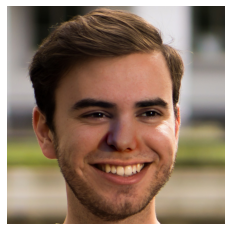

In [13]:
img_path=r'/content/real-and-fake-face-detection/real_and_fake_face/training_fake/easy_101_0010.jpg'
img=plt.imread(img_path)
print ('Input image shape is ',img.shape)
plt.axis('off')
imshow(img)

***Define preprocess function to read in image file and create dataframes***

In [14]:
def preprocess (sdir, trsplit, vsplit):
    filepaths=[]
    labels=[]    
    classlist=os.listdir(sdir)
    for klass in classlist:
        classpath=os.path.join(sdir,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)            
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df= train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
     # check that each dataframe has the same number of classes to prevent model.fit errors
    trcount=len(train_df['labels'].unique())
    tecount=len(test_df['labels'].unique())
    vcount=len(valid_df['labels'].unique())
    if trcount < tecount :         
        msg='** WARNING ** number of classes in training set is less than the number of classes in test set'
        print_in_color(msg, (255,0,0), (55,65,80))
        msg='This will throw an error in either model.evaluate or model.predict'
        print_in_color(msg, (255,0,0), (55,65,80))
    if trcount != vcount:
        msg='** WARNING ** number of classes in training set not equal to number of classes in validation set' 
        print_in_color(msg, (255,0,0), (55,65,80))
        msg=' this will throw an error in model.fit'
        print_in_color(msg, (255,0,0), (55,65,80))
        print ('train df class count: ', trcount, 'test df class count: ', tecount, ' valid df class count: ', vcount) 
        ans=input('Enter C to continue execution or H to halt execution')
        if ans =='H' or ans == 'h':
            print_in_color('Halting Execution', (255,0,0), (55,65,80))
            import sys
            sys.exit('program halted by user')            
    print(list(train_df['labels'].value_counts()))
    return train_df, test_df, valid_df
    

In [15]:
sdir=r'/content/real-and-fake-face-detection/real_and_fake_face'
trsplit=.9
vsplit=.05
train_df, test_df, valid_df= preprocess(sdir,trsplit, vsplit)

train_df length:  1836   test_df length:  103   valid_df length:  102
[972, 864]


***The train data set is not balanced. To balance it limit maximum samples in a class
to 360 samples. Create augmented images for under represented classes so all classes in training set have 130 samples***

In [16]:
max_samples= 530
min_samples=0
column='labels'
working_dir = r'./'
img_size=(300,300)
train_df=trim(train_df, max_samples, min_samples, column)

Original Number of classes in dataframe:  2
[530, 530]


***Create train, test and validation generators***



In [17]:
channels=3
batch_size=20
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
trgen=ImageDataGenerator( horizontal_flip=True)
tvgen=ImageDataGenerator()
msg='                                                              for the train generator'
print(msg, '\r', end='') 
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='                                                              for the test generator'
print(msg, '\r', end='') 
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
msg='                                                             for the validation generator'
print(msg, '\r', end='')
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))
labels=test_gen.labels

test batch size:  1   test steps:  103
Found 1060 validated image filenames belonging to 2 classes.
Found 103 validated image filenames belonging to 2 classes.
Found 102 validated image filenames belonging to 2 classes.


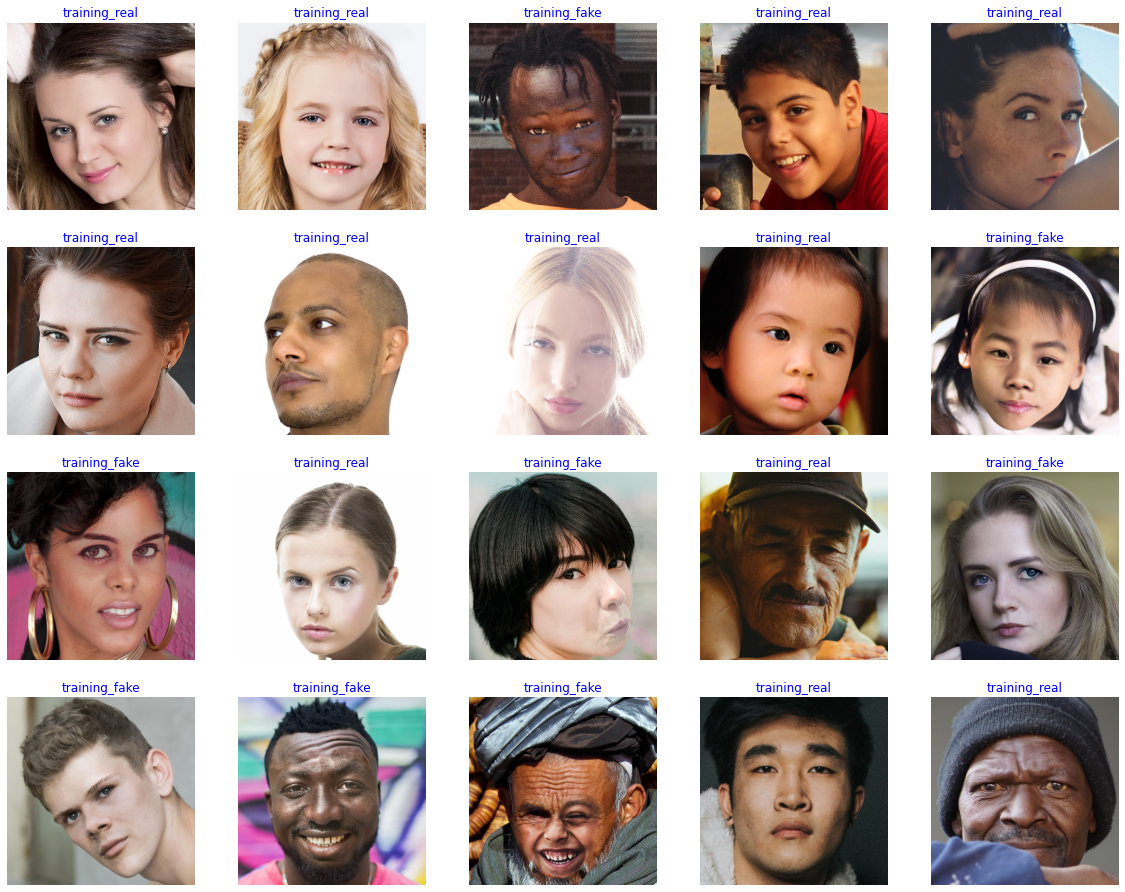

In [18]:
show_image_samples(train_gen)


**Create and Compile the Model**

In [19]:
model_name='EfficientNetB4'
base_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

***Instantiate the Custom Callback and train the***

In [20]:
epochs =4
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=10 # number of epochs to run before asking if you want to halt training
batches=train_steps
csv_path=os.path.join(working_dir,'my_csv')
callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch, csv_path=csv_path )]

In [21]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting training with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /4      8.375   55.566   8.59531  64.706   0.00100  0.00100  accuracy     0.00   1924.14 

 2 /4      6.561   74.906   6.50500  75.490   0.00100  0.00100  accuracy    34.80   1860.72 

 3 /4      5.514   83.396   5.49873  74.510   0.00100  0.00100  accuracy    11.34   1836.40 

 4 /4      4.695   89.623   4.81979  79.412   0.00100  0.00100  accuracy     7.47   1845.72 

Training is completed - model is set with weights from epoch 4 

training elapsed time was 2.0 hours,  4.0 minutes, 49.26 seconds)



In [22]:
from tensorflow.keras.layers import LSTM,Bidirectional,TimeDistributed,Flatten,MaxPooling2D,MaxPooling3D,GlobalAveragePooling3D,GlobalAveragePooling2D,GlobalAveragePooling1D
model_1 = Sequential()
model_1.add(TimeDistributed(Flatten(input_shape=(600,3))))
model_1.add(Dropout(0.2))
model_1.add(Bidirectional(LSTM(units= 250 , return_sequences=True)))
model_1.add(Dropout(0.2))
model_1.add(Bidirectional(LSTM(units= 250 , return_sequences=True)))
model_1.add(Dropout(0.2))
model_1.add(Bidirectional(LSTM(units= 250 , return_sequences=True)))
model_1.add(Dropout(0.2))
model_1.add(Bidirectional(LSTM(units= 250 , return_sequences=True)))
model_1.add(Dropout(0.2))
model_1.add(Bidirectional(LSTM(units= 250)))
model_1.add(Dropout(0.2))
model_1.add(Dense(class_count,activation='softmax'))

In [23]:
model_1.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# history_1=model_1.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
#                validation_steps=None,  shuffle=False,  initial_epoch=0)

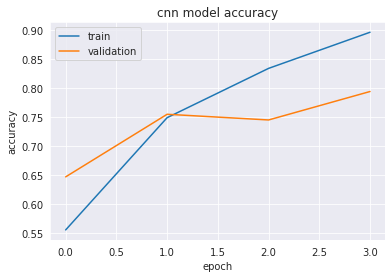

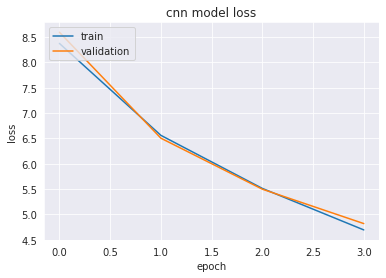

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('cnn model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('cnn model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plt.plot(history_1.history['accuracy'])
# plt.plot(history_1.history['val_accuracy'])
# plt.title('rnn model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# # "Loss"
# plt.plot(history_1.history['loss'])
# plt.plot(history_1.history['val_loss'])
# plt.title('rnn model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()


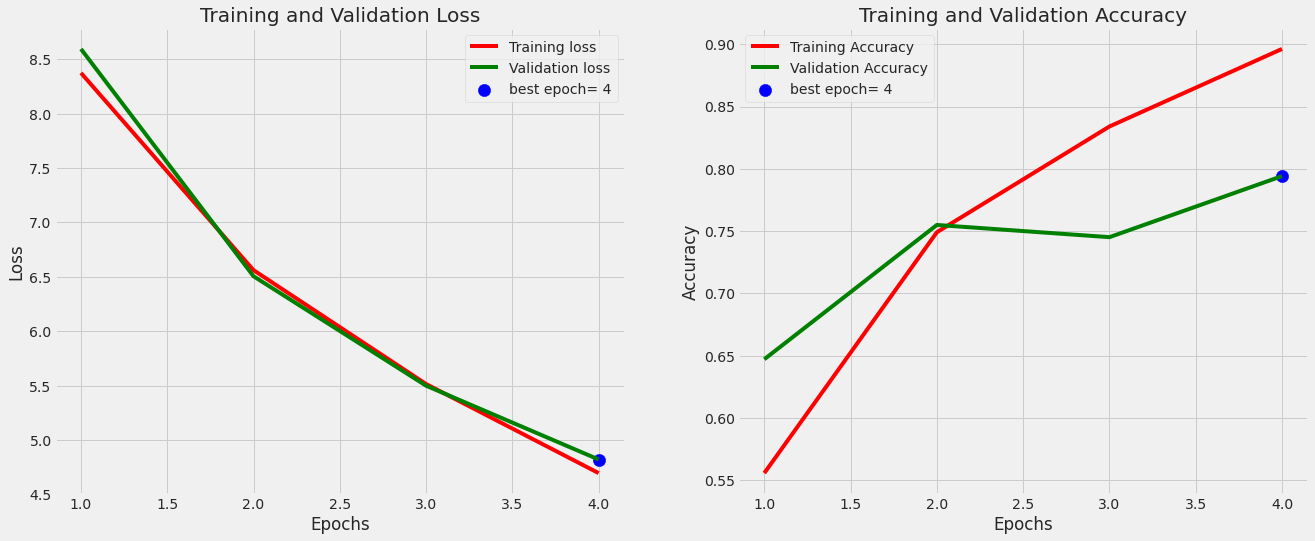

In [26]:
tr_plot(history,0)
# tr_plot(history_1,0)


***Cnn Model***

103/103 [==============================] - 48s 417ms/step
There were 35 errors in 103 test cases Model accuracy=  66.02 %

          Filename                Predicted Class                True Class           Probability   

training_fake/easy_182_0100.jpg       training_real               training_fake            0.9991

training_fake/mid_298_0001.jpg       training_real               training_fake            0.9254

training_fake/easy_212_0010.jpg       training_real               training_fake            0.9288

training_real/real_00682.jpg       training_fake               training_real            0.9877

training_fake/hard_170_0111.jpg       training_real               training_fake            0.9381

training_real/real_00867.jpg       training_fake               training_real            0.9582

training_fake/easy_91_1000.jpg       training_real               training_fake            0.9158

training_fake/mid_455_0101.jpg       training_real               training_fake            

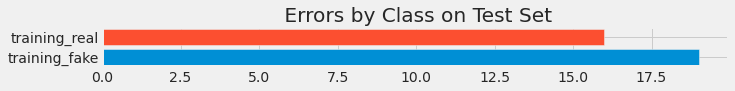

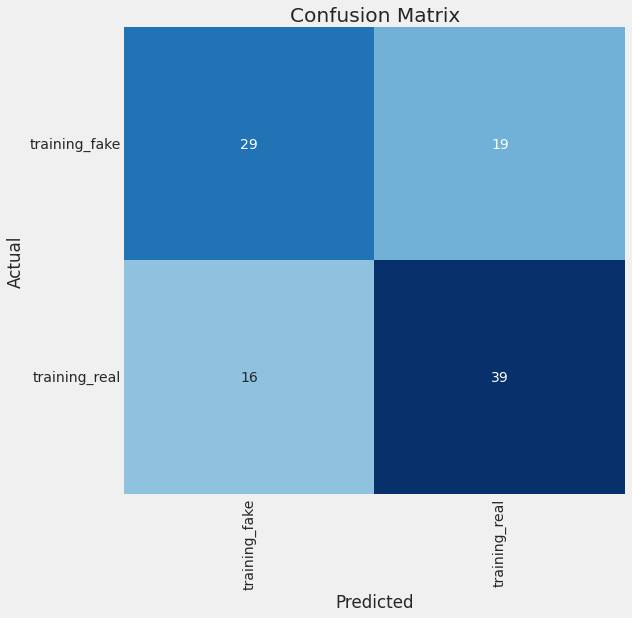

Classification Report:
----------------------
                precision    recall  f1-score   support

training_fake     0.6444    0.6042    0.6237        48
training_real     0.6724    0.7091    0.6903        55

     accuracy                         0.6602       103
    macro avg     0.6584    0.6566    0.6570       103
 weighted avg     0.6594    0.6602    0.6592       103



In [27]:
subject='real or fake'
print_code=10
preds=model.predict(test_gen) 
acc=print_info( test_gen, preds, print_code, working_dir, subject ) 

***rnn model***

In [28]:
# subject='real or fake'
# print_code=10
# preds=model_1.predict(test_gen) 
# acc=print_info( test_gen, preds, print_code, working_dir, subject ) 


***cnn model predict***

Input image shape is  (600, 600, 3)
the resized image has shape  (300, 300, 3)
image shape after expanding dimensions is  (1, 300, 300, 3)
1/1 [==============================] - 5s 5s/step
the shape of prediction is  (1, 2)
the image is predicted as being training_fake with a probability of  99.20 %


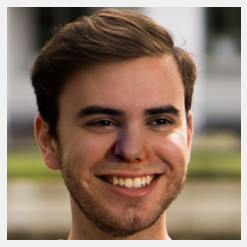

In [29]:
img=plt.imread(img_path)
print ('Input image shape is ', img.shape)
# resize the image so it is the same size as the images the model was trained on
img=cv2.resize(img, img_size) # in earlier code img_size=(224,224) was used for training the model
print ('the resized image has shape ', img.shape)
### show the resized image
plt.axis('off')
plt.imshow(img)
# Normally the next line of code rescales the images. However the EfficientNet model expects images in the range 0 to 255
# img= img/255
# plt.imread returns a numpy array so it is not necessary to convert the image to a numpy array
# since we have only one image we have to expand the dimensions of img so it is off the form (1,224,224,3)
# where the first dimension 1 is the batch size used by model.predict
img=np.expand_dims(img, axis=0)
print ('image shape after expanding dimensions is ',img.shape)
# now predict the image
pred=model.predict(img)
print ('the shape of prediction is ', pred.shape)
# this dataset has 15 classes so model.predict will return a list of 15 probability values
# we want to find the index of the column that has the highest probability
index=np.argmax(pred[0])
# to get the actual Name of the class earlier Imade a list of the class names called classes
klass=classes[index]
# lets get the value of the highest probability
probability=pred[0][index]*100
# print out the class, and the probability 
print(f'the image is predicted as being {klass} with a probability of {probability:6.2f} %')

***rnn model predict***

In [30]:
# img=plt.imread(img_path)
# print ('Input image shape is ', img.shape)
# # resize the image so it is the same size as the images the model was trained on
# img=cv2.resize(img, img_size) # in earlier code img_size=(224,224) was used for training the model
# print ('the resized image has shape ', img.shape)
# ### show the resized image
# plt.axis('off')
# plt.imshow(img)
# # Normally the next line of code rescales the images. However the EfficientNet model expects images in the range 0 to 255
# # img= img/255
# # plt.imread returns a numpy array so it is not necessary to convert the image to a numpy array
# # since we have only one image we have to expand the dimensions of img so it is off the form (1,224,224,3)
# # where the first dimension 1 is the batch size used by model.predict
# img=np.expand_dims(img, axis=0)
# print ('image shape after expanding dimensions is ',img.shape)
# # now predict the image
# pred=model_1.predict(img)
# print ('the shape of prediction is ', pred.shape)
# # this dataset has 15 classes so model.predict will return a list of 15 probability values
# # we want to find the index of the column that has the highest probability
# index=np.argmax(pred[0])
# # to get the actual Name of the class earlier Imade a list of the class names called classes
# klass=classes[index]
# # lets get the value of the highest probability
# probability=pred[0][index]*100
# # print out the class, and the probability 
# print(f'the image is predicted as being {klass} with a probability of {probability:6.2f} %')

In [31]:
model.save("my_h5_model.h5")

In [32]:
!pip install cvlib
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import cvlib as cv
                    
# load model
# model = load_model('gender_detection.model')

# open webcam
webcam = cv2.VideoCapture(1)
    
classes = ['easy','real']

# loop through frames
while webcam.isOpened():

    # read frame from webcam 
    status, frame = webcam.read()

    # apply face detection
    face, confidence = cv.detect_face(frame)


    # loop through detected faces
    for idx, f in enumerate(face):

        # get corner points of face rectangle        
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]

        # draw rectangle over face
        cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)

        # crop the detected face region
        face_crop = np.copy(frame[startY:endY,startX:endX])

        if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
            continue

        # preprocessing for gender detection model
        face_crop = cv2.resize(face_crop, (96,96))
        face_crop = face_crop.astype("float") / 255.0
        face_crop = img_to_array(face_crop)
        face_crop = np.expand_dims(face_crop, axis=0)

        # apply gender detection on face
        conf = model.predict(face_crop)[0] # model.predict return a 2D matrix, ex: [[9.9993384e-01 7.4850512e-05]]

        # get label with max accuracy
        idx = np.argmax(conf)
        label = classes[idx]

        label = "{}: {:.2f}%".format(label, conf[idx] * 100)

        Y = startY - 10 if startY - 10 > 10 else startY + 10

        # write label and confidence above face rectangle
        cv2.putText(frame, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 255, 0), 2)

    # display output
    cv2.imshow("gender detection", frame)

    # press "Q" to stop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release resources
webcam.release()
cv2.destroyAllWindows()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [34]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [35]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [36]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [38]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    classes = ['easy','real']
   
    
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      faces = cv2.resize(faces.astype('float64'), (300,300)) 
      faces = faces.astype("float") 
      faces = img_to_array(faces)
      faces = np.expand_dims(faces, axis=0)
      conf = model.predict(faces)[0]
      idx = np.argmax(conf)
      label = classes[idx]
      label = "{}: {:.2f}%".format(label, conf[idx] * 100)
      cv2.putText(bbox_array,label,(x,y),cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 255, 0), 2)



    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
    # classes = ['easy','real']
    # conf = model_1.predict(faces)
    # idx = np.argmax(conf)
    # label = classes[idx]
    # label = "{}: {:.2f}%".format(label, conf[idx] * 100)
    # cv2.putText(frame, label,(x,y),cv2.FONT_HERSHEY_SIMPLEX,
    #                 0.7, (0, 255, 0), 2)


In [41]:
# conf = model.predict(face_crop)[0] 

In [ ]:
# img_size

In [ ]:
# pred = model.predict(faces)

In [ ]:
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.models import load_model
# import numpy as np
# import cv2
# import os
# import cvlib as cv
                    
# # load model
# # model = load_model('gender_detection.model')

# # open webcam
# webcam = cv2.VideoCapture(0)
    
# classes = ['man','woman']

# # loop through frames
# while webcam.isOpened():

#     # read frame from webcam 
#     status, frame = webcam.read()

#     # apply face detection
#     face, confidence = cv.detect_face(frame)


#     # loop through detected faces
#     for idx, f in enumerate(face):

#         # get corner points of face rectangle        
#         (startX, startY) = f[0], f[1]
#         (endX, endY) = f[2], f[3]

#         # draw rectangle over face
#         cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)

#         # crop the detected face region
#         face_crop = np.copy(frame[startY:endY,startX:endX])

#         if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
#             continue

#         # preprocessing for gender detection model
#         face_crop = cv2.resize(face_crop, (96,96))
#         face_crop = face_crop.astype("float") / 255.0
#         face_crop = img_to_array(face_crop)
#         face_crop = np.expand_dims(face_crop, axis=0)

#         # apply gender detection on face
#         conf = model.predict(face_crop)[0] # model.predict return a 2D matrix, ex: [[9.9993384e-01 7.4850512e-05]]

#         # get label with max accuracy
#         idx = np.argmax(conf)
#         label = classes[idx]

#         label = "{}: {:.2f}%".format(label, conf[idx] * 100)

#         Y = startY - 10 if startY - 10 > 10 else startY + 10

#         # write label and confidence above face rectangle
#         cv2.putText(frame, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
#                     0.7, (0, 255, 0), 2)

#     # display output
#     cv2.imshow("gender detection", frame)

#     # press "Q" to stop
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # release resources
# webcam.release()
# cv2.destroyAllWindows()

In [ ]:
# video_stream()

In [ ]:

# start streaming video from webcam
# def camera(): 
#   video_stream()
#   # label for video
#   label_html = 'Capturing...'
#   # initialze bounding box to empty
#   bbox = ''
#   count = 0 
#   while True:
#     js_reply = video_frame(label_html, bbox)
#     if not js_reply:
#         break

In [ ]:
# camera